# Sentiment analysis model to classify movie reviews as positive or negative

Text classification

In [1]:
#importing libraries

import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

# Load and explore directory structure

In [2]:
#extract file from url address
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 25s 0us/step


In [3]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

The aclImdb/train/pos and aclImdb/train/neg directories contain many text files,having each of the single movie review

In [5]:
#removing the additional folder unsup so as prepare datset for binary classification of class_a & class_b

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

The dataset got divided into train and test, but lacks a validation set.\
Creating a validation set using an 80:20 split of the training data by using the validation_split argument.

In [6]:
batch_size = 32
seed = 42

raw_train_ds= tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [7]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [8]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [10]:
#iterating over the dataset
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])
    
#class_name property of the dataset   
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Review b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up."
Label 1
Review b'Caution: May contain spoilers...<br /><br />I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for general distribution instead of made for TV.<

# Prepare the dataset for training

- Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.\
- Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting  on whitespace).\
- Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer

In [11]:
#writing standardized function to remove the HTML tags from the text reveiw
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

- Creating a TextVectorization layer,to standardize, tokenize, and vectorize our data.\
- The output mode is set to int to create unique integer indices for each token.


In [12]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [13]:
# call adapt to fit the state of the preprocessing layer to the dataset, using the training data
# Make a text-onltrain_datasty dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [14]:
#creating a function to see the result of using this layer to preprocess some data.
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [15]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label",raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4, 1233, 1021,   27,  261,  101,    4,    1, 1525,
        6992,  248,   32, 1488,    1, 1659,    4,

- As seen above, each token has been replaced by an integer.\
- Use .get_vocabulary() on the layer to llokup the token (string) that each integer corresponds to


In [16]:
print("260 ---> ",vectorize_layer.get_vocabulary()[260])
print(" 2 ---> ",vectorize_layer.get_vocabulary()[2])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

260 --->  especially
 2 --->  the
Vocabulary size: 10000


In [17]:
# apply the TextVectorization layer created earlier to the train, validation, and test dataset.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Configuring the dataset for performance

Two important methods used when loading data to make sure that I/O does not become blocking are:\
- .cache() keeps data in memory after it's loaded off disk.\
- .prefetch() overlaps data preprocessing and model execution while training.

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Creating the model

In [19]:
#create neural network
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

The layers are stacked sequentially to build the classifier:

- The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).\
- Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.\
  This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units\.
-The last layer is densely connected with a single output node.

# Loss function and optimizer

- Loss function is needed by a model and an optimizer for training.

In [20]:
# configure the model to use an optimizer and a loss function
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Training the model

In [21]:
#passing the dataset object to fit method
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 31s 45ms/step - loss: 0.6666 - binary_accuracy: 0.6833 - val_loss: 0.6184 - val_binary_accuracy: 0.7694
Epoch 2/10
625/625 [==============================] - 5s 9ms/step - loss: 0.5515 - binary_accuracy: 0.7993 - val_loss: 0.5006 - val_binary_accuracy: 0.8192
Epoch 3/10
625/625 [==============================] - 5s 9ms/step - loss: 0.4467 - binary_accuracy: 0.8429 - val_loss: 0.4213 - val_binary_accuracy: 0.8464
Epoch 4/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3794 - binary_accuracy: 0.8650 - val_loss: 0.3745 - val_binary_accuracy: 0.8598
Epoch 5/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3374 - binary_accuracy: 0.8778 - val_loss: 0.3459 - val_binary_accuracy: 0.8682
Epoch 6/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3062 - binary_accuracy: 0.8885 - val_loss: 0.3267 - val_binary_accuracy: 0.8712
Epoch 7/10
625/625 [==============================] - 5s 9ms/s

# Evaluating the model

In [22]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 90s 114ms/step - loss: 0.3101 - binary_accuracy: 0.8730
Loss:  0.31009015440940857
Accuracy:  0.8730000257492065


# Creating a plot of accuracy and loss over time

In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

-  These are four entries above: one for each monitored metric during training and validation.
-  using these enteries to plot the training and validation loss for comparison, as well as the training and validation accuracy.

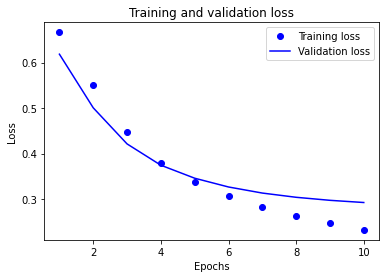

In [24]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

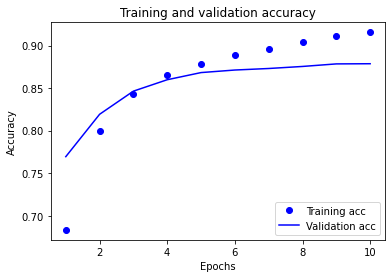

In [25]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

- From the above graphs, the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.
- This is not the case for the validation loss and accuracy,both seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

- Export the model: 
wanting to make your model capable of processing raw strings (for example, to simplify deploying it),the TextVectorization layer can be included inside your model. This is done by creating a new model using the weights just trained.

In [26]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 14s 18ms/step - loss: 0.3101 - accuracy: 0.8730
0.8730000257492065


# Inference on new data

In [27]:
# To get predictions for new examples,call model.predict()

examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 322ms/step


array([[0.6535639 ],
       [0.48047814],
       [0.3951432 ]], dtype=float32)